In [1]:
import cv2
import numpy as np
import math
import copy
import pprint
import matplotlib.pyplot as plt

# Чтение и изменение размера для удобства смотреть

In [2]:
#image = cv2.imread(r"D:\Зубарев (D)\Старое\фото с микроскопа\ПФЛ по рисунку 12-02 11-03 11-01 12-08 12-07 12-13\Az 9260 11-03\2 без ФР\06-DC 1_2.jpg")
img = cv2.imread(r"C:\Users\22080\Desktop\06-DC 1_2.jpg")

scale_percent = 50 # Процент от изначального размера
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

#cv2.imshow("Image", resized)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Использумые функции

In [3]:
def four_lines_check(img_flc, line): #opencv.image, numpy.ndarray
# проверям. все ли границы распознаны   
    storage = np.array([])
    step = img_flc.shape[0] / 100
    ruler = img_flc.shape[0] * 0.9
    deleted_col = int(0)
    #print('ruler', ruler)
    #print('step', step)
    line_ret = copy.deepcopy(line)
    if line is not None:
        for x in range(0, len(line)):
            if line[x][0][1] > ruler: # внизу. где линейка
                line_ret = np.delete(arr=line_ret, obj=(x-deleted_col), axis=0)
                deleted_col += 1
            p1 = True
            for i in line[x]:
                for j in storage:
                    if abs(i[1] -j) < step:
                        p1 = False
            if p1:
                storage = np.append(storage, line[x][0][1])
                               
        storage = storage[storage <= ruler]

        return line_ret, True if len(storage) == 4 else False, storage
    else:
        return line_ret, False, storage

def make_position(storage): #numpy.ndarray
# список: mp[0] - индекс наименьшего. mp[1] - индекс следующего..
    return storage.argsort(kind='quicksort', axis=0)

def equal_from_lines(img_efl, line, storage_flc): #opencv.image,  numpy.ndarray
# выводим уравнения прямых для расчёта расстояния    
    # делим на 4 близких массива по шагу
    step = img_efl.shape[0] / 100
    #print(storage_flc)
    dots = np.array([storage_flc]).reshape(4,1).astype(int).tolist()
    #print('initialize dots', dots)
    for x in range(0, len(line)):
        #print('line[x]', line[x])
        for i in line[x]:
            #print('len(dot)', len(dots))
            for j in range(0, len(dots)):
                #print('i, j',i[1], dots[j])
                if abs(i[1] - dots[j][0]) < step:
                    #dots = np.insert(arr=dots, obj=x, values=i[1])
                    dots[j].append([i])
                    #print('успех', dots)
                    
    for i in range(4): # убираем значения storage
        dots[i] = dots[i][1:]
    #pprint.pprint(dots[0])                   
    
    equals = [[],[],[],[]]
    for i in range(0, len(dots)):
        # для каждой группы линий
        for j in dots[i]:
            # для каждой линии
            #print('j', j)
            a = j[0][3] - j[0][1]
            b = 1
            c = ( a*(j[0][0]) + (j[0][0] - j[0][2])*(j[0][1]) ) / ( (j[0][0] - j[0][2]) ) 
            equals[i].append([a,b,c])
    #pprint.pprint(equals)
    
    res = np.array([[]])
    for i in equals:
        # для каждой группы линий
        a = int(0)
        b = int(0)
        c = int(0)
        for j in i:
            a += j[0]
            b += j[1]
            c += j[2]
        a = a / len(i)
        b = b / len(i)
        c = c / len(i)         
        res = np.append(res,[[a,b,c]], axis=1)
    return res.reshape(4,3)

def dots_from_lines(img_efl, line, storage_flc): #opencv.image,  numpy.ndarray
# делим на группы по storage     
    # делим на 4 близких массива по шагу
    step = img_efl.shape[0] / 100
    dots = np.array([storage_flc]).reshape(4,1).astype(int).tolist()
    for x in range(0, len(line)):
        for i in line[x]:
            for j in range(0, len(dots)):
                if abs(i[1] - dots[j][0]) < step:
                    dots[j].append([i])
                    
    for i in range(4): # убираем значения storage
        dots[i] = dots[i][1:]
    return dots

def space_point_line(point, coefs): # list[x,y], list[a,b,c]
    return abs( coefs[0]*point[0] + coefs[1]*point[1] - coefs[2])

# Трансформация Хафа

In [4]:
#           РАБОЧАЯ          СЕКЦИЯ 
gray = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize = 3)

minLineLength = 1000
maxLineGap = 30 # можно 60, меньше линий
lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength,maxLineGap)
lines = four_lines_check(resized, lines)[0] # убрали где линейка

while not four_lines_check(resized, lines)[1]: # если осталось ровно 4 линии. только не зацикливайся
    minLineLength -= 50
    maxLineGap -= 5
    lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength,maxLineGap)
    lines = four_lines_check(resized, lines)[0]

for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(resized,(x1,y1),(x2,y2),(0,255,0),2) # рисуем линии
        
flc_result = four_lines_check(resized, lines)
dots = dots_from_lines(resized, lines, flc_result[2]) 
equals = equal_from_lines(resized, lines, flc_result[2]) 
positions = make_position(flc_result[2])        

rasst12 = space_point_line(dots[  positions[0]  ][0][0][0:2], equals[  positions[1]  ])
rasst34 = space_point_line(dots[  positions[2]  ][0][0][0:2], equals[  positions[3]  ])
rasst23 = space_point_line(dots[  positions[1]  ][0][0][0:2], equals[  positions[2]  ])

# пересчёт в микрометры. начальная высота 1544, ширина 2080
# после уменьшения 772х1040
# линейка для 100х объектива (увеличнения 50х): 145 пикселей = 10мкм, без учёта уменьшения
# один пиксель = 10 / 145 мкм

print('верх', rasst12*10/141*2, 'низ', rasst34*10/141*2, 'электрод', rasst23*10/141*2 )

cv2.imshow('Hough transform',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

верх 13.049645390070921 низ 13.179669030732855 электрод 13.698074974670718


In [5]:
cv2.imshow('Hough transform',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

# FAST: Features from Accelerated Segment Test

верх 12.807388630319146 низ 8.667393523025892 электрод 13.774111051085994


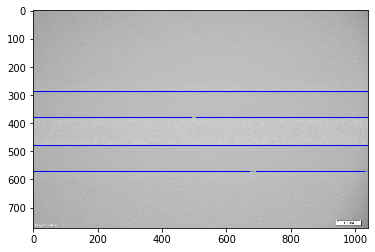

In [28]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY); # 'RGB2GRAY'

# Create default Fast Line Detector class
fld = cv2.ximgproc.createFastLineDetector()
# Get line vectors from the image
lines = fld.detect(gray)

# Убираем в области линейки
lines = four_lines_check(resized, lines)[0] # убрали где линейка

flc_result = four_lines_check(resized, lines)
dots = dots_from_lines(resized, lines, flc_result[2]) 
equals = equal_from_lines(resized, lines, flc_result[2]) 
positions = make_position(flc_result[2])        

rasst12 = space_point_line(dots[  positions[0]  ][0][0][0:2], equals[  positions[1]  ]) # верх
rasst34 = space_point_line(dots[  positions[2]  ][0][0][0:2], equals[  positions[3]  ]) # центр
rasst23 = space_point_line(dots[  positions[1]  ][0][0][0:2], equals[  positions[2]  ]) # низ

# пересчёт в микрометры. начальная высота 1544, ширина 2080
# после уменьшения 772х1040
# линейка для 100х объектива (увеличнения 50х): 145 пикселей = 10мкм, без учёта уменьшения
# один пиксель = 10 / 145 мкм

print('верх', rasst12*10/141*2, 'низ', rasst34*10/141*2, 'электрод', rasst23*10/141*2 )

# Draw lines on the image
line_on_image = fld.drawSegments(resized, lines)
# Plot
plt.imshow(line_on_image, interpolation='nearest', aspect='auto')
plt.show()

# Ещё раз рисуем для OpenCV
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(resized,(x1,y1),(x2,y2),(0,255,0),2) # рисуем линии

cv2.imshow('hough',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [32]:
cv2.imshow('FAST line detector',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#cv.imwrite("./экспорт/путь.расширение", image)